# The *lac* Operon

In this note, we use the *lac* operon in the bacterium *E. coli* as an example of gene regulation to study common phenomena in dynamical systems with feedback control, including "all-or-none" transition and bistability.

The *lac* operon is a group of genes in *E. coli* under the control of a common promoter. These genes encode proteins that are essential for the utilization of lactose, including a permease (*LacY*) that helps transporting lactose into the cell and an enzyme (*LacZ*) that helps catabolizing lactose. The promoter is repressed in the presence of glucose and in the absence of lactose, resulting in low levels of expression of the genes. However, when there is no glucose and the amount of lactose crosses a certain threshold, those genes turn on quickly to enable the cell to utilize lactose. The transition happens because lactose produces a molecule, the "inducer", which blocks the repression of the *lac* operon, thus facilitating the expression of the genes. Then the products of these genes further increase the uptake and breakdown of lactose, forming a positive feedback. It is this positive feedback that results in the all-or-none behavior of the gene expression.  
<img src="source/lac-operon.png" alt="lac-operon.png" align="center" width="400"/>

We can simplify the description of the above processes by modeling only the inducer and the transporter, the latter representing the general expression level of genes within the *lac* operon. In the simplified description, essentially, the inducer promotes the production of the transporter, and the transporter in turn helps increase the amount of inducers in the cell.  
<img src="source/inducer-transporter.png" alt="inducer-transporter.png" align="center" width="200"/>

Let us model the dynamics of the inducer and transporter as follows. Denote the abundance of the inducer by $X$ and that of the transporter by $Y$. We can write:
\begin{align}
\dot{X} &= g(Y) - \gamma X \\
\dot{Y} &= f(X) - \mu Y
\end{align}
In the first equation, the function $g(Y)$ describes how the transporter increases the amount of the inducer, and $\gamma$ is the rate at which the inducer is degraded. In the second equation, the function $f(X)$ describes how the inducer promotes the production of the transporter, and $\mu$ is the degradation rate of the transporter. When there are not too many inducers, the uptake rate of inducers is roughly proportional to the number of transporters; therefore, we have $g(Y) \approx \kappa Y$. Moreover, we will assume that inducers can be added to the cell externally, which can be represented by an additional source term in the $\dot{X}$ equation, $\xi$. Finally, we assume that the production of the transporter depends on the amount of inducer in the form of a sigmoidal function, such as the Hill function, $f(X) = \lambda X^n / (X^n + K^n)$ for some coefficient $n$. This function starts from 0 when $X=0$, increases monotonically, and saturates at the level $\lambda$ when $X \gg K$, where $K$ is the half saturation point (see figure below).

Therefore, our dynamical equations become:
\begin{align}
\dot{X} &= \kappa Y - \gamma X + \xi \\
\dot{Y} &= f(X) - \mu Y, \qquad f(X) = \frac{\lambda X^n}{X^n + K^n}
\end{align}
Without loss of generality, we can set $\kappa = \lambda = \mu = 1$ (by rescaling $X$, $Y$, and time). Then we are left with 3 parameters, $\gamma, K, n$, and one control variable $\xi$. That is,
\begin{align}
\dot{X} &= Y - \gamma X + \xi \\
\dot{Y} &= f(X) - Y, \qquad f(X) = \frac{X^n}{X^n + K^n}
\end{align}

We are interested in the steady state, where the time derivatives vanish. We will first solve for steady states using a graphical method, then verify the stability of these states by numerically solving the dynamical equations. To start, let us program these equations, which mean defining the time derivatives (right-hand side of the equations) as functions of the variables.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def equations(XY, t, gam, xi, K, n):    # calculate time derivatives (time t is kept as a parameter for later use of `odeint`)
    X, Y = XY    # parse variables
    dXdt = Y - gam * X + xi
    dYdt = X**n / (X**n + K**n) - Y
    return [dXdt, dYdt]

## Steady states

Setting the time derivatives to zero, we have the equations:
\begin{align}
Y &= \gamma X - \xi \\
Y &= f(X) = \frac{X^n}{X^n + K^n}
\end{align}
which both describe $Y$ as a function of $X$. Since they have to hold simultaneously, the solution would be given by the intersection of the two curves representing these functions. This can be found by plotting these functions on the same figure. For the parameters, let us choose $K=1$ and $n=2$, and vary the value of $\gamma$. We will first consider the case $\xi=0$, i.e., no external source.

In [3]:
def func1(X, gam, xi):    # first function above
    Y = gam * X - xi
    return Y

def func2(X, K, n):    # second function above (Hill function)
    Y = X**n / (X**n + K**n)
    return Y

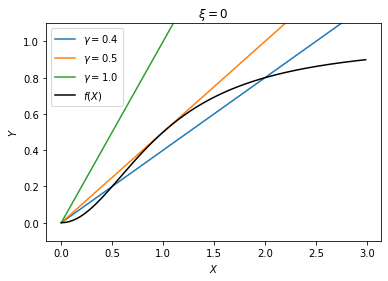

In [4]:
K = 1.0    # half saturation point for Hill function
n = 2    # Hill coefficient
xi = 0    # external source, set to zero for now
gam_list = [0.4, 0.5, 1.0]    # values of gamma to plot

x_array = np.arange(0, 3, 0.01)
f_array = func2(x_array, K, n)    # Hill function

plt.figure()
for gam in gam_list:
    y_array = func1(x_array, gam, xi)    # linear function with given gam
    plt.plot(x_array, y_array, label=r'$\gamma=%.1f$' % gam)    # plot straight lines with different slopes
plt.plot(x_array, f_array, 'k', label=r'$f(X)$')    # plot Hill function
plt.ylim(-0.1, 1.1)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title(r'$\xi = 0$')
plt.legend()
plt.show()

It can be seen that, for a large $\gamma$ ($\gamma > 0.5$), there is only one solution at the origin, whereas for a small $\gamma$ ($\gamma < 0.5$), there are three solutions, one at the origin, another on the plateau of the function $f(X)$, and a third one in between. The latter case will be considered below (see [Bistability](#Bistability)); here we focus on the case with only one solution, e.g., $\gamma = 1$.

With this choice of parameters, the only steady state the system will go to is $X=0, Y=0$. That means both the inducer and the transporter are "off", because the inducer is being degraded too fast and cannot sustain the positive feedback loop. Let us now study how the solution changes with the external source $\xi$. We expect to see that the genes are off when there is no external source, but will turn on when the external source increases to a certain level.

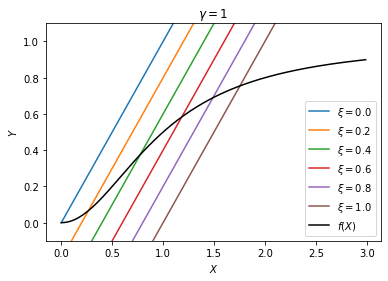

In [5]:
gam = 1.0    # keep gamma fixed
xi_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]    # vary xi

plt.figure()
for xi in xi_list:
    y_array = func1(x_array, gam, xi)
    plt.plot(x_array, y_array, label=r'$\xi=%.1f$' % xi)    # plot straight lines
plt.plot(x_array, f_array, 'k', label=r'$f(X)$')    # plot Hill function
plt.ylim(-0.1, 1.1)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title(r'$\gamma = 1$')
plt.legend()
plt.show()

For all values of $\xi$, there is only one solution, which will be the stable steady state of the system. As $\xi$ increases, the solution moves up the plateau quickly, indicating a sharp transition.

To visualize the transition, we would like to plot the solution as a function of $\xi$. For that, we need to find the solution numerically for a given set of parameters. This can be done using the `scipy.optimize.root` function. We have already defined the time derivatives in our function `equations` above.

In [6]:
import scipy.optimize as opt

In [7]:
xi = 0.2

x0 = [0.5, 0.5]    # initial guess of solution, 2-d vector (X0,Y0)
sol = opt.root(equations, x0, args=(0, gam, xi, K, n))    # find root of equations(x)==0 with initial guess x0
Xs, Ys = sol.x    # unpack solution vector (Xs,Ys)
print(f'xi = {xi:.3f}, steady state: Xs = {Xs:.3f}, Ys = {Ys:.3f}', end='\r')

Now we can find the solution for different values of $\xi$ by repeating the steps above. Then we can plot the equilibrium value of $Y$ as a function of $\xi$.

In [8]:
xi_list = np.arange(0, 3, 0.05)    # list of xi values
Xs_list = []    # steady state of X for each value of xi
Ys_list = []    # steady state of Y for each value of xi

for xi in xi_list:
    x0 = [0.5, 0.5]    # initial guess of solution, 2-d vector (X0,Y0)
    sol = opt.root(equations, x0, args=(0, gam, xi, K, n))    # finding root of equations(x)==0 with initial guess x0
    Xs, Ys = sol.x    # unpack solution vector (Xs,Ys)
    print(f'xi = {xi:.3f}, steady state: Xs = {Xs:.3f}, Ys = {Ys:.3f}', end='\r')
    Xs_list.append(Xs)
    Ys_list.append(Ys)

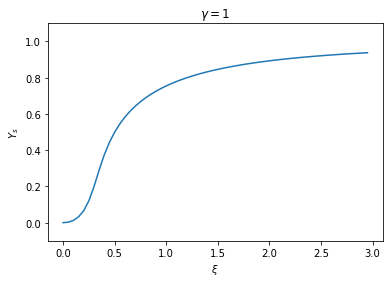

In [9]:
plt.figure()
plt.plot(xi_list, Ys_list)
plt.ylim(-0.1, 1.1)
plt.xlabel(r'$\xi$')
plt.ylabel(r'$Y_s$')
plt.title(r'$\gamma = 1$')
plt.show()

We see that the steady state of $Y$ turns "on" sharply near a value $\xi \approx 0.5$. That means, if the external source is below this threshold, the *lac* genes are largely off; yet when the external source crosses the threshold, the expression of the *lac* genes will be induced. In the latter case, the expression level quickly saturates as a result of the positive feedback. Therefore we observe an almost "all-or-none" response.

## Stability of steady states

By definition, a steady state is such that the time derivatives of the dynamical system vanish. Therefore, once the system is at such a state *exactly*, it will never change. However, this does not necessarily mean that the steady state is *stable*. A steady state is stable if the system perturbed away from the state will return to it; otherwise, the steady state is unstable. Therefore, to check if a steady state is stable or not, we need to examine the *dynamics* of the system, not just the stationary solutions that we studied above.

The stability of a steady state can be analyzed by expanding the dynamical equations around the steady state (we will do this in class). Alternatively, we may solve the dynamical equations numerically and see where the trajectories flow starting from various initial states. If trajectories converge to certain points as time goes to infinity, these points will be stable steady states.

Let us use this method to check the stability of the steady states found above using the graphical method. To solve the dynamical equations, we may use the `scipy.integrate.odeint` function that we used for solving rate equations before. Let us look at an example where $\xi = 0.2$, which is below the threshold, so we expect the genes to be off.

In [10]:
import scipy.integrate as intgr

In [11]:
gam = 1.
xi = 0.2

num = 10    # number of trajectories to test
X_init = np.random.rand(num) * 3    # random initial values for X between 0 and 3
Y_init = np.random.rand(num) * 1    # random initial values for Y between 0 and 1
traj_list = []

T = 50.    # total time to integrate the trajectory
time_points = np.arange(0, T, 0.1)    # time points to evaluate solutions

for i in range(num):
    X0, Y0 = X_init[i], Y_init[i]    # initial values
    traj = intgr.odeint(equations, [X0, Y0], time_points, args=(gam, xi, K, n))
    traj_list.append(traj)

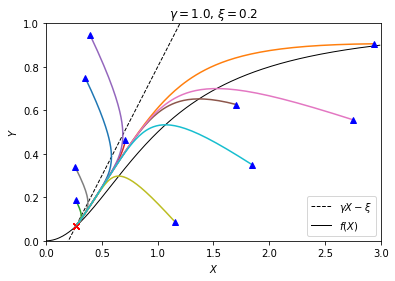

In [12]:
x_array = np.arange(0, 3, 0.01)
y_array = func1(x_array, gam, xi)
f_array = func2(x_array, K, n)

plt.figure()
plt.plot(x_array, y_array, 'k--', lw=1, label=r'$\gamma X - \xi$')    # plot straight line
plt.plot(x_array, f_array, 'k-', lw=1, label=r'$f(X)$')    # plot Hill function
for traj in traj_list:
    plt.plot(traj[:,0], traj[:,1])    # plot trajectory
    plt.plot([traj[0,0]], [traj[0,1]], 'b^')    # blue triangle marks initial state
    plt.plot([traj[-1,0]], [traj[-1,1]], 'rx')    # red X marks final state
plt.xlim(0, 3)
plt.ylim(0, 1)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title(r'$\gamma = %.1f$, $\xi = %.1f$' % (gam, xi))
plt.legend(loc='lower right')
plt.show()

We see that, no matter where the trajectories start, they all converge to the same point --- the steady state we found above using the graphical method (intersection of the black curves). It confirms that, in this case where only one steady state exists, the steady state is stable.

## Bistability

Let us now look at the case where $\xi = 0$ and $\gamma < 0.5$, e.g., $\gamma = 0.4$. According to the graphical solution above, we now have three steady states. It turns out that the one at the origin and the one on the plateau are stable, but the one in the middle is unstable --- with any small perturbation the system will leave that state and go to either of the other two steady states. The existence of two stable steady states in a dynamical system is called "bistability".

Let us make a similar plot of trajectories to visualize this bistable case.

In [13]:
gam = 0.4
xi = 0

num = 20    # number of trajectories to test
X_init = np.random.rand(num) * 3    # random initial values for X between 0 and 3
Y_init = np.random.rand(num) * 1    # random initial values for Y between 0 and 1
traj_list = []

T = 50.    # total time to integrate the trajectory
time_points = np.arange(0, T, 0.1)    # time points to evaluate solutions

for i in range(num):
    X0, Y0 = X_init[i], Y_init[i]    # initial values
    traj = intgr.odeint(equations, [X0, Y0], time_points, args=(gam, xi, K, n))
    traj_list.append(traj)

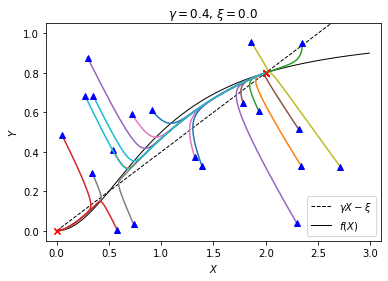

In [14]:
x_array = np.arange(0, 3, 0.01)
y_array = func1(x_array, gam, xi)
f_array = func2(x_array, K, n)

plt.figure()
plt.plot(x_array, y_array, 'k--', lw=1, label=r'$\gamma X - \xi$')    # plot straight line
plt.plot(x_array, f_array, 'k-', lw=1, label=r'$f(X)$')    # plot Hill function
for traj in traj_list:
    plt.plot(traj[:,0], traj[:,1])    # plot trajectory
    plt.plot([traj[0,0]], [traj[0,1]], 'b^')    # blue triangle marks initial state
    plt.plot([traj[-1,0]], [traj[-1,1]], 'rx')    # red square marks final state
plt.xlim(-0.1, 3.1)
plt.ylim(-0.05, 1.05)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title(r'$\gamma = %.1f$, $\xi = %.1f$' % (gam, xi))
plt.legend(loc='lower right')
plt.show()

You may see some trajectories that go to the origin and others that go to the steady state on the right, but no trajectories that go to the middle steady state because it is unstable.

Another fancy way of visualizing potential trajectories is to make a stream plot. This is like plotting field lines of electromagnetic fields. We first pick grid points where the vector field will be evaluated. The arrows will be automatically drawn and joint together to form field lines by the `streamplot` function.

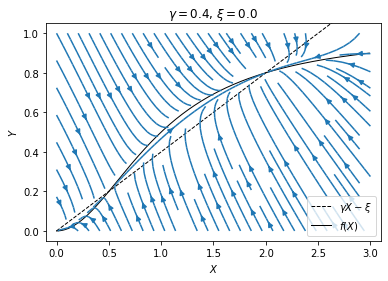

In [15]:
x_points = np.arange(0, 3.1, 0.1)    # grid lines for x-axis
y_points = np.arange(0, 1.1, 0.1)    # grid lines for y-axis
x_grid, y_grid = np.meshgrid(x_points, y_points)    # generate a grid of x, y values

x_flow, y_flow = equations([x_grid, y_grid], 0, gam, xi, K, n)    # vector fields (set t=0 as equations do not depend on t)

plt.figure()
plt.plot(x_array, y_array, 'k--', lw=1, label=r'$\gamma X - \xi$')    # plot straight line
plt.plot(x_array, f_array, 'k-', lw=1, label=r'$f(X)$')    # plot Hill function
plt.streamplot(x_grid, y_grid, x_flow, y_flow)    # plot field lines
plt.xlim(-0.1, 3.1)
plt.ylim(-0.05, 1.05)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title(r'$\gamma = %.1f$, $\xi = %.1f$' % (gam, xi))
plt.legend(loc='lower right')
plt.show()

From the figure we see that, for initial values near the lower left corner of the plot, the system will flow to the origin, whereas for initial values in the rest part of the plot, the system will flow to the steady state on the right. That means the expression of the *lac* genes can in principle turn on and off stochastically: Suppose the genes are off initially. If there happens to be a fluctuation that pushes the system to the upper right region, then the genes will turn on, and will remain on under small perturbations. However, if there is then a large fluctuation that pushes the system back to the lower left region, then the genes will turn off again and remain so until another large fluctuation. The fact that the genes can turn on automatically by chance makes this situation sound unbiological. Indeed, it does not seem to happen for the native inducer. However, people have shown the potential for such bistability in the lac operon using synthetic inducers.

## Hysteresis

When there is bistability, what happens if we add external source of the inducer, i.e., increasing $\xi$? Consider the case where $\gamma = 0.55$, just above the critical value such that there is no bistability at $\xi = 0$. Let us make a similar plot as above to find how the steady states change as $\xi$ increases.

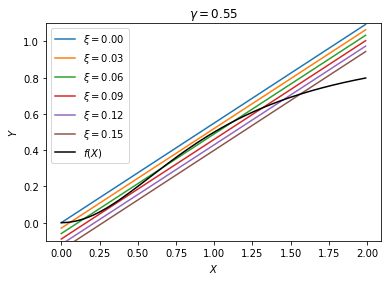

In [16]:
gam = 0.55
xi_list = np.arange(0, 0.17, 0.03)

x_array = np.arange(0, 2, 0.01)
f_array = func2(x_array, K, n)

plt.figure()
for xi in xi_list:
    y_array = func1(x_array, gam, xi)
    plt.plot(x_array, y_array, label=r'$\xi=%.2f$' % xi)    # plot straight line
plt.plot(x_array, f_array, 'k', label=r'$f(X)$')    # plot Hill function
plt.ylim(-0.1, 1.1)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title(r'$\gamma = %.2f$' % gam)
plt.legend()
plt.show()

We see that, somewhere between $\xi = 0.03$ and $0.09$, there is bistability where we have two stable steady states, ON and OFF. Let us denote these two critical values $\xi^-$ and $\xi^+$, respectively. For $\xi < \xi^-$, the only steady state is OFF, whereas for $\xi > \xi^+$, the only steady state is ON. But if we are in the bistable region $\xi^- < \xi < \xi^+$, the system can in principle be either ON or OFF.

What determines whether the genes are ON or OFF in the bistable region? That depends on the history of the system. If we start from below $\xi^-$, so that initially the genes are OFF, then when we enter the bistable region, the genes will remain OFF since the OFF state is locally stable. If we continue to increase $\xi$, then the genes will eventually turn ON when $\xi$ reaches $\xi^+$, because at that point ON becomes the only stable state. However, if we start from above $\xi^+$, so that the genes are initially ON, then the opposite happens as we decrease $\xi$, i.e., the genes will remain ON until $\xi$ reaches $\xi^-$.

These two processes can be visualized by the following plot of the steady state $Y_s$ as a function of $\xi$. There are two branches of steady states that coexist within the bistable region. We can make this plot by solving the steady state equations as above, only that now we have to be careful about the initial guesses of the root. When we increase $\xi$ from below, our initial guess should be near the OFF state, whereas when we decrease $\xi$ from above, we need to use an initial guess near the ON state.

In [17]:
gam = 0.55
xi_list = np.arange(0, 0.15, 0.001)    # list of xi values

Xs_incr = []    # steady state of X when increasing xi
Ys_incr = []    # steady state of Y when increasing xi
for xi in xi_list:
    x0 = [0, 0]    # initial guess of solution, near the OFF state
    sol = opt.root(equations, x0, args=(0, gam, xi, K, n))    # finding root of equations(x)==0
    if not sol.success:    # did not find root near initial guess
        x0 = [1.5, 0.7]    # try again with a different guess near the ON state
        sol = opt.root(equations, [1.5, 0.7], args=(0, gam, xi, K, n))
    Xs, Ys = sol.x    # unpack solution vector (Xs,Ys)
    print(f'xi = {xi:.3f}, steady state: Xs = {Xs:.3f}, Ys = {Ys:.6f}', end='\r')
    Xs_incr.append(Xs)
    Ys_incr.append(Ys)

Xs_decr = []    # steady state of X when decreasing xi
Ys_decr = []    # steady state of Y when decreasing xi
for xi in xi_list[::-1]:    # reverse order in xi list
    x0 = [1.5, 0.7]    # initial guess of solution, near the ON state
    sol = opt.root(equations, x0, args=(0, gam, xi, K, n))    # finding root of equations(x)==0
    if not sol.success:    # did not find root near initial guess
        x0 = [0, 0]    # try again with a different guess near the OFF state
        sol = opt.root(equations, [0, 0], args=(0, gam, xi, K, n))
    Xs, Ys = sol.x    # unpack solution vector (Xs,Ys)
    print(f'xi = {xi:.3f}, steady state: Xs = {Xs:.3f}, Ys = {Ys:.6f}', end='\r')
    Xs_decr.append(Xs)
    Ys_decr.append(Ys)

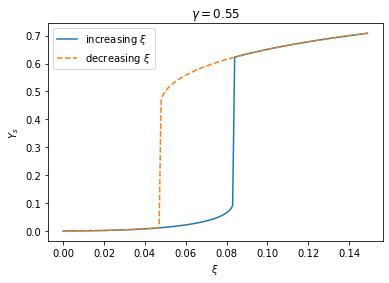

In [18]:
plt.figure()
plt.plot(xi_list, Ys_incr, label=r'increasing $\xi$')
plt.plot(xi_list[::-1], Ys_decr, '--', label=r'decreasing $\xi$')
plt.xlabel(r'$\xi$')
plt.ylabel(r'$Y_s$')
plt.legend(loc='upper left')
plt.title(r'$\gamma = %.2f$' % gam)
plt.show()

Such history-dependent response, or "hysteresis", is very typical of bistable dynamical systems. 